# Set-Up

In [ ]:
# Install Requirements

!pip install -r requirements.txt

In [ ]:
# Import packages

import os
from pathlib import Path
import sys
import math
import json
import collections
import requests
import pandas as pd
import numpy as np
import rasterio
from rasterio.warp import transform_bounds
from rasterio.merge import merge
import xml.etree.ElementTree as ET
from shapely.ops import unary_union, transform as shp_transform
from shapely import wkt as shp_wkt
from shapely.geometry import box as shp_box
from pyproj import Transformer
from urllib.parse import quote
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.patches import Rectangle
from affine import Affine
from rasterio.shutil import copy as rio_copy
from rasterio.io import MemoryFile
from collections import deque
from math import ceil, sqrt
import time
import zipfile
from matplotlib.ticker import FuncFormatter

# Import copernicus login
sys.path.insert(0, str(Path.cwd().parents[0]))  
from copernicus_login import username, password

In [2]:
# CDSE Query Functions

# Auth + basic HTTP
def get_access_and_refresh_token(username, password):
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "cdse-public",
    }
    r = requests.post(url, data=data)
    r.raise_for_status()
    js = r.json()
    return js["access_token"], js["refresh_token"]

def refresh_access_token(refresh_token):
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "refresh_token",
        "refresh_token": refresh_token,
        "client_id": "cdse-public",
    }
    r = requests.post(url, data=data, headers={"Content-Type": "application/x-www-form-urlencoded"})
    r.raise_for_status()
    return r.json()["access_token"]

def make_api_request(url, method="GET", data=None, headers=None):
    # minimal retry on 401/403 using global tokens
    global access_token, refresh_token
    if not headers:
        headers = {"Authorization": f"Bearer {access_token}"}
    resp = requests.request(method, url, json=data, headers=headers)
    if resp.status_code in (401, 403):
        access_token = refresh_access_token(refresh_token)
        headers["Authorization"] = f"Bearer {access_token}"
        resp = requests.request(method, url, json=data, headers=headers)
    return resp


# Geometry helpers 
def get_combined_bounds(tif_dir):
    geoms = []
    for fname in os.listdir(tif_dir):
        if fname.lower().endswith(".tif"):
            with rasterio.open(os.path.join(tif_dir, fname)) as src:
                b = transform_bounds(src.crs, "EPSG:4326", *src.bounds)
                geoms.append(shp_box(*b))
    return unary_union(geoms)

def bounds_to_wkt(bounds_geom):
    return bounds_geom.wkt


# Catalogue query
def query_sentinel2_for_tif_area(start_date, end_date, token, wkt_polygon, min_cloud=0, max_cloud=20):
    all_rows = []
    filter_string = (
        f"Collection/Name eq 'SENTINEL-2' and "
        f"Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/Value eq 'S2MSI2A') and "
        f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/Value ge {min_cloud}) and "
        f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/Value le {max_cloud}) and "
        f"ContentDate/Start gt {start_date}T00:00:00.000Z and ContentDate/Start lt {end_date}T23:59:59.999Z"
    )

    next_url = (
        "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
        f"$filter={filter_string} and OData.CSC.Intersects(area=geography'SRID=4326;{wkt_polygon}')"
        "&$top=100&$expand=Attributes"
    )
    headers = {"Authorization": f"Bearer {token}"}

    while next_url:
        r = make_api_request(next_url, headers=headers)
        r.raise_for_status()
        js = r.json()
        all_rows.extend(js.get("value", []))
        next_url = js.get("@odata.nextLink")

    return pd.DataFrame(all_rows)

# Formatting helpers
def format_sentinel2_results(df_raw):
    out = []
    for _, row in df_raw.iterrows():
        cloud_cover = None
        for att in row.get("Attributes", []):
            if att.get("Name") == "cloudCover":
                cloud_cover = att.get("Value")
                break

        cd = row.get("ContentDate", {})
        name = row.get("Name", "")
        out.append({
            "ProductID": row["Id"],
            "ProductName": name,
            "AcquisitionDate": cd.get("Start", "")[:10],
            "Tile": name.split("_")[5] if "_" in name else "Unknown",
            "Size (MB)": round(int(row["ContentLength"]) / 1e6, 2),
            "DownloadPath": row.get("S3Path"),
            "FootprintWKT": row.get("Footprint"),
            "CloudCover": cloud_cover,
            "SunZenithMean": None,
            "SunAzimuthMean": None,
            "ViewZenithMean": None,
            "ViewAzimuthMean": None,
        })
    return pd.DataFrame(out)


# Node traversal
def _nodes_array(js):
    # CDSE may return 'result' or 'value'
    if isinstance(js, dict):
        if isinstance(js.get("result"), list):
            return js["result"]
        if isinstance(js.get("value"), list):
            return js["value"]
    return []

def list_nodes(product_id, headers, uri=None, node_id=None):
    if uri:
        url = uri
    else:
        base = f"https://download.dataspace.copernicus.eu/odata/v1/Products({product_id})"
        url = f"{base}/Nodes" if node_id is None else f"{base}/Nodes({node_id})/Nodes"
    r = make_api_request(url, headers=headers)
    r.raise_for_status()
    return _nodes_array(r.json())

def find_tile_metadata_download_url(product_id, headers, max_nodes=3000):
    """
    BFS following each folder's Nodes.uri; when we see a file named 'MTD_TL*.xml',
    return a direct $value URL. Minimal checks, prioritized GRANULE path.
    """
    roots = list_nodes(product_id, headers=headers)  # /Products(pid)/Nodes
    if not roots:
        return None

    top_nodes_uri = f"https://download.dataspace.copernicus.eu/odata/v1/Products({product_id})/Nodes"
    q = collections.deque((n, top_nodes_uri) for n in roots)
    visited = 0

    while q and visited < max_nodes:
        node, parent_nodes_uri = q.popleft()
        visited += 1

        name = (node.get("Name") or "").strip()
        children_num = node.get("ChildrenNumber", 0)
        nodes_uri = (node.get("Nodes") or {}).get("uri")

        # File: check for tile metadata
        if children_num == 0 and name.upper().startswith("MTD_TL") and name.lower().endswith(".xml"):
            # parent_nodes_uri ends with .../Nodes, append (file)/$value
            return f"{parent_nodes_uri}({quote(name, safe='-._~')})/$value"

        # Folder: enqueue children; explore GRANULE first
        if children_num > 0 and nodes_uri:
            kids = list_nodes(product_id, headers=headers, uri=nodes_uri)
            kids.sort(key=lambda k: (k.get("ChildrenNumber", 0) == 0, k.get("Name") != "GRANULE", k.get("Name","")))
            for ch in kids:
                q.append((ch, nodes_uri))

    return None


# XML parsing (angles)
def _to_float(x):
    try:
        return float(x)
    except Exception:
        return None

def parse_angles_from_tile_xml(xml_bytes):
    root = ET.fromstring(xml_bytes)

    # Sun mean angles: Tile_Angles/Mean_Sun_Angle/{ZENITH_ANGLE, AZIMUTH_ANGLE}
    sun_zen = _to_float(root.findtext(".//{*}Tile_Angles/{*}Mean_Sun_Angle/{*}ZENITH_ANGLE"))
    sun_azi = _to_float(root.findtext(".//{*}Tile_Angles/{*}Mean_Sun_Angle/{*}AZIMUTH_ANGLE"))

    # Viewing incidence angles (per band/detector) -> average
    vzen, vazi = [], []
    for vi in root.findall(".//{*}Mean_Viewing_Incidence_Angle"):
        z = _to_float((vi.findtext(".//{*}ZENITH_ANGLE")))
        a = _to_float((vi.findtext(".//{*}AZIMUTH_ANGLE")))
        if z is not None: vzen.append(z)
        if a is not None: vazi.append(a)

    view_zen = float(np.mean(vzen)) if vzen else None
    view_azi = float(np.mean(vazi)) if vazi else None

    return {
        "SunZenithMean": sun_zen,
        "SunAzimuthMean": sun_azi,
        "ViewZenithMean": view_zen,
        "ViewAzimuthMean": view_azi,
    }


# DF enricher
def enrich_with_angles(df, token, print_first_url=True):
    headers = {"Authorization": f"Bearer {token}"}
    first_url_printed = False

    for i, row in df.iterrows():
        pid = row["ProductID"]
        xml_url = find_tile_metadata_download_url(pid, headers=headers)
        if not xml_url:
            print(f"[angles] No MTD_TL*.xml found for {pid}")
            continue

        r = make_api_request(xml_url, headers=headers)
        r.raise_for_status()
        ang = parse_angles_from_tile_xml(r.content)
        for k, v in ang.items():
            df.at[i, k] = v

    return df

# =========================
# QUERY EXECUTION
# =========================

# Credentials 
username = username
password = password

# LiDAR tif directory 
tif_path = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_lidar"

# Bounds -> WKT
bounds_geom = get_combined_bounds(tif_path)
wkt_poly = bounds_to_wkt(bounds_geom)

# Define date range (+/- 14 days from LiDAR date)
start_date = "2024-04-04"
end_date   = "2024-05-02"

# Tokens
access_token, refresh_token = get_access_and_refresh_token(username, password)

# Query catalogue
df_raw = query_sentinel2_for_tif_area(
    start_date=start_date,
    end_date=end_date,
    token=access_token,
    wkt_polygon=wkt_poly,
    min_cloud=0,
    max_cloud=100
)

# Format + cloud cover
df_results = format_sentinel2_results(df_raw)

# Solar + viewing angles (prints the first XML URL)
df_results = enrich_with_angles(df_results, access_token, print_first_url=True)

# Show results
pd.set_option("display.max_columns", None)
df_results.head()

ProductID  \
0  1c88628a-e3b5-483a-ab62-11f263459c45   
1  fbe46452-249c-4aaf-9c9a-6287baaa2468   
2  e4c15ec8-bad7-4588-8827-48d95d520f0a   
3  180e065a-d622-48b6-9de8-10288e44b2d9   
4  4fa4210c-9c63-4760-97f3-dc6467f532b6   

                                         ProductName AcquisitionDate    Tile  \
0  S2A_MSIL2A_20240416T185921_N0510_R013_T12WXB_2...      2024-04-16  T12WXB   
1  S2A_MSIL2A_20240416T185921_N0510_R013_T13WDS_2...      2024-04-16  T13WDS   
2  S2B_MSIL2A_20240418T184919_N0510_R113_T12WXB_2...      2024-04-18  T12WXB   
3  S2B_MSIL2A_20240418T184919_N0510_R113_T13WDS_2...      2024-04-18  T13WDS   
4  S2B_MSIL2A_20240428T184919_N0510_R113_T12WXB_2...      2024-04-28  T12WXB   

   Size (MB)                                       DownloadPath  \
0     850.41  /eodata/Sentinel-2/MSI/L2A/2024/04/16/S2A_MSIL...   
1     847.91  /eodata/Sentinel-2/MSI/L2A/2024/04/16/S2A_MSIL...   
2     488.05  /eodata/Sentinel-2/MSI/L2A/2024/04/18/S2B_MSIL...   
3     720.31  /eodata/Sentinel-2/MSI/L2A/2024/04/18/S2B_MSIL...   
4     517.54  /eodata/Sentinel-2/MSI/L2A/2024/04/28/S2B_MSIL...   

                                        FootprintWKT  CloudCover  \
0  geography'SRID=4326;POLYGON ((-108.45373396353...   99.885046   
1  geography'SRID=4326;POLYGON ((-107.54728328448...   99.973977   
2  geography'SRID=4326;POLYGON ((-107.99847402389...   99.972194   
3  geography'SRID=4326;POLYGON ((-107.48778316352...   99.981916   
4  geography'SRID=4326;POLYGON ((-107.97981417848...   74.390990   

  SunZenithMean SunAzimuthMean ViewZenithMean ViewAzimuthMean  
0     58.372306     179.130863       4.042345       120.86051  
1     58.410459     180.297555       2.809624      174.991384  
2     57.711369     176.350472        9.24483      114.240456  
3     57.731825     177.524997       7.774089      114.367719  
4     54.415502     176.782477       9.251313      114.123961

In [3]:
# Ensure Sentinel-2 products have 100% coverage of the LiDAR region

# LiDAR BBOX in WGS84
def lidar_bbox_polygon(tif_dir):
    boxes = []
    for fname in os.listdir(tif_dir):
        if not fname.lower().endswith(".tif"):
            continue
        fp = os.path.join(tif_dir, fname)
        with rasterio.open(fp) as ds:
            # densify to handle curved edges during reprojection
            b = transform_bounds(ds.crs, "EPSG:4326", *ds.bounds, densify_pts=21)
            boxes.append(shp_box(*b))
    if not boxes:
        raise RuntimeError("No TIFFs found for bbox computation.")
    return unary_union(boxes).buffer(0)

bbox_ll = lidar_bbox_polygon(tif_path)       # WGS84 polygon
if bbox_ll.is_empty:
    raise RuntimeError("LiDAR bbox is empty.")

# Equal-area transform for area ratios (world cyl. equal area)
to_eq = Transformer.from_crs("EPSG:4326", "EPSG:6933", always_xy=True)
bbox_eq = shp_transform(lambda x, y: to_eq.transform(x, y), bbox_ll)
bbox_area = bbox_eq.area

# Footprint parser 
def parse_footprint_ll(row):
    """
    Returns a Shapely geometry in WGS84 lon/lat.
    Accepts your df column 'FootprintWKT' (from format step),
    or falls back to 'Footprint'/'GeoFootprint' if present.
    Handles SRID=...; and geography'...'.
    """
    w = row.get("FootprintWKT") or row.get("Footprint") or row.get("GeoFootprint")
    if not w:
        return None
    if isinstance(w, str):
        s = w.strip()
        # Strip geography'...'
        if s.lower().startswith("geography"):
            first = s.find("'")
            last  = s.rfind("'")
            if first != -1 and last != -1 and last > first:
                s = s[first+1:last]
        # Strip SRID=xxxx; prefix if present
        if s.upper().startswith("SRID="):
            s = s.split(";", 1)[-1].strip()
        try:
            g = shp_wkt.loads(s)
            if not g.is_valid:
                g = g.buffer(0)
            return g if not g.is_empty else None
        except Exception:
            return None
    return None

# Area coverage checks
def area_fraction_cover(prod_ll, bbox_ll, to_eq):
    prod_eq = shp_transform(lambda x, y: to_eq.transform(x, y), prod_ll)
    inter = prod_eq.intersection(bbox_eq).area
    den = bbox_eq.area if bbox_eq.area > 0 else 1.0
    return float(inter / den)

def product_covers_bbox(prod_ll, bbox_ll, tol=1e-9):
    # Strict topological covers (tolerant to tiny slivers with buffer(0))
    g = prod_ll.buffer(0)
    b = bbox_ll.buffer(0)
    return g.covers(b)

def coverage(prod_ll):
    frac = area_fraction_cover(prod_ll, bbox_ll, to_eq)
    covers = product_covers_bbox(prod_ll, bbox_ll)
    return frac, covers, False

# Compute per-product coverage
cov_frac_list, covers_list, swapped_list = [], [], []
for _, r in df_results.iterrows():
    g_ll = parse_footprint_ll(r)
    if g_ll is None:
        cov_frac_list.append(0.0); covers_list.append(False); swapped_list.append(False)
        continue
    frac, cov, did_swap = coverage(g_ll)
    cov_frac_list.append(frac); covers_list.append(cov); swapped_list.append(did_swap)

df_results["CoverageFracBBox"] = cov_frac_list
df_results["CoversBBox"] = covers_list
df_results["AxisSwapFallbackUsed"] = swapped_list

# Probe products
probe_id = "b0b5386b-83a9-4434-b3e6-5de5b680a269"
probe = df_results.loc[df_results["ProductID"] == probe_id]
if len(probe):
    pr = probe.iloc[0]
    print("\n--- Probe product ---")
    print("Name:", pr["ProductName"])
    print("CoverageFracBBox:", pr["CoverageFracBBox"])
    print("CoversBBox:", pr["CoversBBox"])

# ==============================
# FULL COVERAGE FILTER EXECUTION
# ==============================
FULL_THRESH = 0.999
df_full = df_results[(df_results["CoversBBox"]) | (df_results["CoverageFracBBox"] >= FULL_THRESH)].copy()

print(f"\nCandidates: {len(df_results)}  |  Full coverage: {len(df_full)}")
df_full[["ProductID","ProductName","AcquisitionDate","CloudCover","CoverageFracBBox","AxisSwapFallbackUsed"]].sort_values("CoverageFracBBox", ascending=False).head(20)


Candidates: 36  |  Full coverage: 17


ProductID  \
1   fbe46452-249c-4aaf-9c9a-6287baaa2468   
3   180e065a-d622-48b6-9de8-10288e44b2d9   
6   21d0d862-5a9a-4dc0-8a73-f6c843c73bd7   
7   007a1428-8a9e-4de4-9bbf-1dfa99909d3e   
8   8d20c27d-d9e8-4877-8670-a9c2db12d9e6   
9   54e28238-f931-41dd-9f4b-1ebcccdb027c   
10  c96d37f9-1c8d-41c8-b54e-fec597bc85b4   
11  f3e63462-fc8a-4edd-bbf6-ff019702f1cf   
14  a0aa23ac-60bd-4985-86bb-203535d10717   
19  c5470b02-2684-4df4-bf32-00c51a97ef99   
27  6c48a539-be65-4a35-9947-9d3903d27a6e   
28  e93b5621-eea1-4218-9a92-e96884ffb3b6   
29  ce1c1e09-e748-4db3-82c5-39adc301c35f   
30  92cd3e55-328c-4072-ac11-2816749547f1   
31  de3b3719-ace2-4b5f-b20b-964171e29b66   
32  76911eab-bf8b-4010-a3bb-1f5d35356486   
34  671ec979-66ee-4895-a3cc-86f2e75316f1   

                                          ProductName AcquisitionDate  \
1   S2A_MSIL2A_20240416T185921_N0510_R013_T13WDS_2...      2024-04-16   
3   S2B_MSIL2A_20240418T184919_N0510_R113_T13WDS_2...      2024-04-18   
6   S2A_MSIL2A_20240426T185921_N0510_R013_T13WDS_2...      2024-04-26   
7   S2B_MSIL2A_20240404T190919_N0510_R056_T13WDS_2...      2024-04-04   
8   S2A_MSIL2A_20240409T190911_N0510_R056_T13WDS_2...      2024-04-09   
9   S2B_MSIL2A_20240408T184919_N0510_R113_T13WDS_2...      2024-04-08   
10  S2B_MSIL2A_20240414T190919_N0510_R056_T13WDS_2...      2024-04-14   
11  S2A_MSIL2A_20240413T184921_N0510_R113_T13WDS_2...      2024-04-13   
14  S2A_MSIL2A_20240423T184931_N0510_R113_T13WDS_2...      2024-04-23   
19  S2B_MSIL2A_20240424T190909_N0510_R056_T13WDS_2...      2024-04-24   
27  S2B_MSIL2A_20240411T185919_N0510_R013_T13WDS_2...      2024-04-11   
28  S2A_MSIL2A_20240419T190921_N0510_R056_T13WDS_2...      2024-04-19   
29  S2A_MSIL2A_20240429T190921_N0510_R056_T13WDS_2...      2024-04-29   
30  S2A_MSIL2A_20240406T185911_N0510_R013_T13WDS_2...      2024-04-06   
31  S2B_MSIL2A_20240428T184919_N0510_R113_T13WDS_2...      2024-04-28   
32  S2B_MSIL2A_20240501T185919_N0510_R013_T13WDS_2...      2024-05-01   
34  S2B_MSIL2A_20240421T185919_N0510_R013_T13WDS_2...      2024-04-21   

    CloudCover  CoverageFracBBox  AxisSwapFallbackUsed  
1    99.973977               1.0                 False  
3    99.981916               1.0                 False  
6    66.379791               1.0                 False  
7     0.034698               1.0                 False  
8    87.412494               1.0                 False  
9    81.311840               1.0                 False  
10   99.322617               1.0                 False  
11    3.612655               1.0                 False  
14   58.169681               1.0                 False  
19   32.018954               1.0                 False  
27   98.327702               1.0                 False  
28   45.611215               1.0                 False  
29   94.011319               1.0                 False  
30    0.016304               1.0                 False  
31   71.598530               1.0                 False  
32   82.360697               1.0                 False  
34    0.652742               1.0                 False

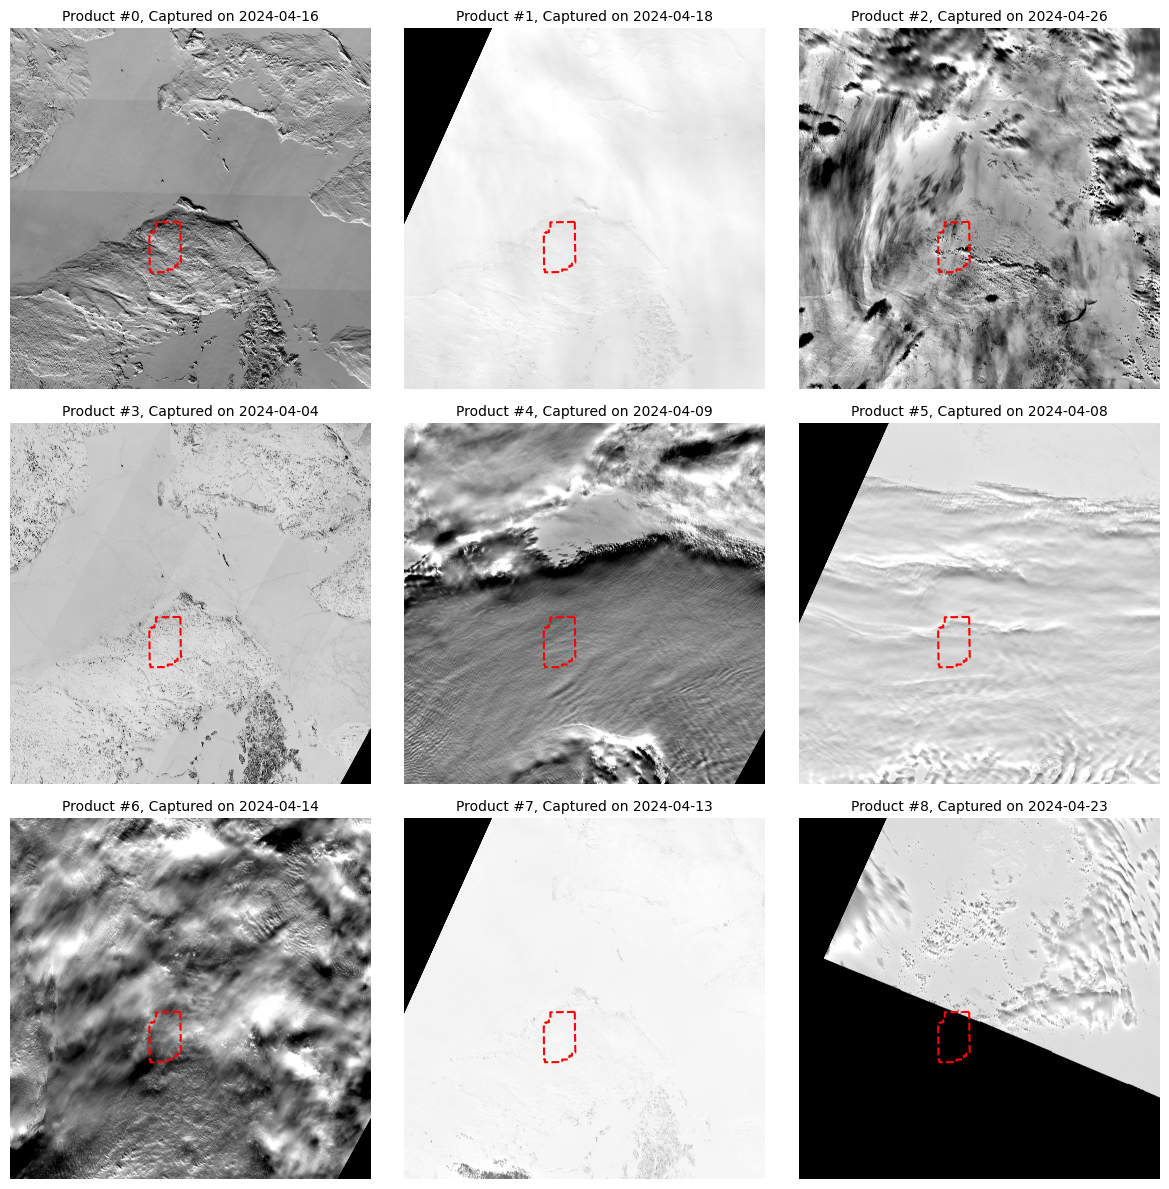

[Auth] Refreshing access token...


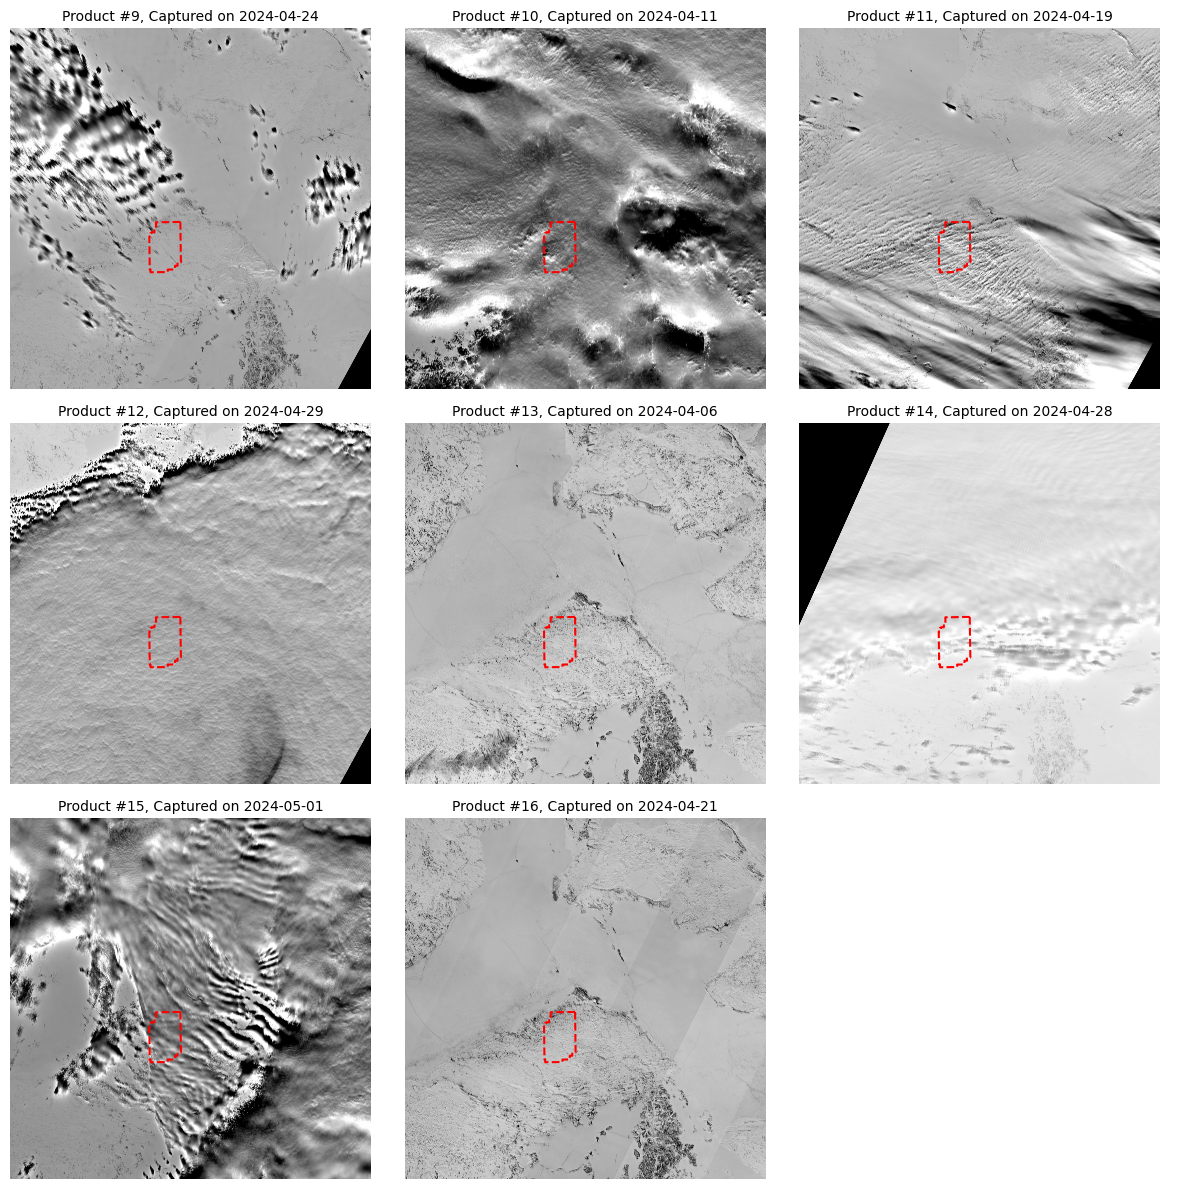

In [4]:
# Visualize products (tiled)


# Define a function to reproject the WGS84 bbox coordinates to the image CRS
def _project_bbox_to_image_crs(bbox_ll, profile):
   """
   Transforms the WGS84 LiDAR bounding box to the CRS of the Sentinel-2 image.


   Args:
       bbox_ll (shapely.geometry.Polygon): The LiDAR bounding box in WGS84.
       profile (dict): The rasterio profile of the Sentinel-2 image.


   Returns:
       np.array: A 2D array of (col, row) coordinates in image space, or None if transformation fails.
   """
   s2_crs = profile["crs"]


   # Create a transformer from WGS84 (EPSG:4326) to the image's CRS
   to_image_crs = Transformer.from_crs("EPSG:4326", s2_crs, always_xy=True)
  
   # Reproject the exterior coordinates of the WGS84 bounding box
   lon, lat = bbox_ll.exterior.coords.xy
   x_proj, y_proj = to_image_crs.transform(lon, lat)
  
   # Combine into projected coordinates
   projected_coords = np.vstack([x_proj, y_proj]).T


   # Transform the projected coordinates (x, y) into (col, row) pixel indices
   # Get the Affine transform from the profile
   transform = profile["transform"]
  
   # Use rasterio's transform to convert world coordinates to pixel indices
   cols, rows = rasterio.transform.rowcol(
       transform,
       projected_coords[:, 0],
       projected_coords[:, 1],
       op=np.floor
   )
  
   # Combine (col, row) and return
   return np.vstack([cols, rows]).T


# Plotting function
def plot_s2_products_tiled(
   df,
   username,
   password,
   bbox_ll=bbox_ll,      # WGS84 LiDAR bbox polygon
   product_id_column="ProductID",
   band_pattern="B04_10m", 
   tiles_per_fig=9,           # max tiles per figure
   cmap="gray",
   stretch=(2, 98),         
   figsize=(12, 12),
   max_nodes=5000,
   timeout=120,
   refresh_interval=30,       # refresh token every 30 seconds
):
   """
   Visualize a single band from each Sentinel-2 product in a tiled layout (max 9 per figure),
   automatically refreshing the Copernicus Data Space access token every 60 seconds.
   """


   # Helpers
   def _find_file_value_url(product_id, headers, pattern, max_nodes=5000):
       roots = list_nodes(product_id, headers=headers)
       if not roots:
           return None


       top_nodes_uri = f"https://download.dataspace.copernicus.eu/odata/v1/Products({product_id})/Nodes"
       q = deque((n, top_nodes_uri) for n in roots)
       visited = 0


       while q and visited < max_nodes:
           node, parent_nodes_uri = q.popleft()
           visited += 1
           name = (node.get("Name") or "").strip()
           children_num = node.get("ChildrenNumber", 0)
           nodes_uri = (node.get("Nodes") or {}).get("uri")


           if children_num == 0 and (pattern in name):
               meta_uri = (node.get("__metadata") or {}).get("uri")
               if meta_uri:
                   return f"{meta_uri}/$value"
               return f"{parent_nodes_uri}({quote(name, safe='')})/$value"


           if children_num > 0 and nodes_uri:
               kids = list_nodes(product_id, headers=headers, uri=nodes_uri)
               for ch in kids:
                   q.append((ch, nodes_uri))
       return None


   def _fetch_band_array_from_product(product_id, token, band_pattern="B04_10m", timeout=120):
       headers = {"Authorization": f"Bearer {token}"}
       candidates = [band_pattern, band_pattern + ".jp2", band_pattern.replace("_10m", "") + "_10m.jp2", ".jp2"]
       url = None
       for pat in candidates:
           url = _find_file_value_url(product_id, headers=headers, pattern=pat, max_nodes=max_nodes)
           if url:
               break
       if not url:
           return None, None


       r = requests.get(url, headers=headers, stream=True, timeout=timeout)
       try:
           r.raise_for_status()
       except Exception:
           return None, None


       with MemoryFile(r.content) as mf:
           with mf.open() as ds:
               arr = ds.read(1).astype(np.float32)
               profile = ds.profile
               nod = ds.nodata
               if nod is not None:
                   arr = np.where(arr == nod, np.nan, arr)
       return arr, profile


   def _percentile_stretch(img, lohi=(2, 98)):
       valid = ~np.isnan(img)
       if not valid.any():
           return np.zeros_like(img, dtype=np.float32)
       lo, hi = np.nanpercentile(img[valid], lohi)
       if hi <= lo:
           lo, hi = np.nanmin(img[valid]), np.nanmax(img[valid])
           if hi <= lo:
               return np.zeros_like(img, dtype=np.float32)
       return np.clip((img - lo) / max(hi - lo, 1e-6), 0, 1)


   # Initialize token and time tracking
   token, refresh_token = get_access_and_refresh_token(username, password)
   last_refresh = time.time()


   # Main plotting loop
   product_ids = df[product_id_column].tolist()
   n = len(product_ids)
   if n == 0:
       print("No products found in dataframe.")
       return


   cols = int(ceil(sqrt(tiles_per_fig)))
   rows = int(ceil(tiles_per_fig / cols))


   for start in range(0, n, tiles_per_fig):
       # Refresh token if interval elapsed
       if time.time() - last_refresh > refresh_interval:
           print("[Auth] Refreshing access token...")
           token, refresh_token = get_access_and_refresh_token(username, password)
           last_refresh = time.time()


       chunk = list(enumerate(product_ids[start:start + tiles_per_fig], start=start))
       fig, axes = plt.subplots(rows, cols, figsize=figsize)
       if isinstance(axes, np.ndarray):
           axes = axes.ravel()
       else:
           axes = [axes]


       for tile_idx in range(rows * cols):
           ax = axes[tile_idx]
           ax.axis("off")


           if tile_idx < len(chunk):
               df_index, product_id = chunk[tile_idx]
               arr, profile = _fetch_band_array_from_product(product_id, token, band_pattern=band_pattern, timeout=timeout)
               if arr is not None:
                   disp = _percentile_stretch(arr, stretch)
                   ax.imshow(disp, cmap=cmap)
                   # Plot LiDAR bounding box on top of image
                   pixel_coords = _project_bbox_to_image_crs(bbox_ll, profile)
                   if pixel_coords is not None:
                       # Plot the projected polygon's boundary (assuming it's a closed loop)
                       # The coordinates are (col, row), which is (x, y) in matplotlib imshow space
                       # Plot as a line, closing the loop by plotting the first point again
                       x_coords = np.append(pixel_coords[:, 0], pixel_coords[0, 0])
                       y_coords = np.append(pixel_coords[:, 1], pixel_coords[0, 1])
                       ax.plot(x_coords, y_coords, color='red', linestyle='--', linewidth=1.5, label='LiDAR BBox')
                   # Get acquisition date from dataframe
                   acquisition_date = df.iloc[df_index]["AcquisitionDate"]
                   ax.set_title(f"Product #{df_index}, Captured on {acquisition_date}", fontsize=10)
               else:
                   ax.text(0.5, 0.5, f"{df_index}\nN/A", ha="center", va="center", fontsize=10)
       plt.tight_layout()
       plt.show()


# ================================
# VISUALIZE FULL COVERAGE PRODUCTS
# ================================
plot_s2_products_tiled(
   df_full,
   username=username,
   password=password,
   bbox_ll=bbox_ll,   
   band_pattern="B04_10m"
)

# Download Data

In [5]:
# Download selected Sentinel-2 products

def _to_float_or_none(v):
    try:
        f = float(v)
        return None if math.isnan(f) else f
    except (TypeError, ValueError):
        return None

def download_single_product(
    product_id,
    file_name,
    access_token,
    download_dir="downloaded_products",
    metadata=None, 
):
    """
    Download a single product and write a sibling JSON with sun/view/cloud attrs.
    """
    os.makedirs(download_dir, exist_ok=True)

    # Download the SAFE zip
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    response = session.get(url, headers=headers, stream=True, timeout=300)

    if response.status_code == 200:
        zip_path = os.path.join(download_dir, file_name + ".zip")
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"Downloaded: {zip_path}")

        # Write attributes JSON next to the zip (from df_results row)
        if metadata is not None:
            # Build a clean, consistent JSON payload
            payload = {
                "product_id": metadata.get("ProductID"),
                "product_name": metadata.get("ProductName"),
                "acquisition_date": metadata.get("AcquisitionDate"),
                "tile": metadata.get("Tile"),
                "cloud_cover": _to_float_or_none(metadata.get("CloudCover")),
                "sun_zenith_mean": _to_float_or_none(metadata.get("SunZenithMean")),
                "sun_azimuth_mean": _to_float_or_none(metadata.get("SunAzimuthMean")),
                "view_zenith_mean": _to_float_or_none(metadata.get("ViewZenithMean")),
                "view_azimuth_mean": _to_float_or_none(metadata.get("ViewAzimuthMean")),
            }
            json_path = os.path.join(download_dir, file_name + "_metadata.json")
            with open(json_path, "w") as jf:
                json.dump(payload, jf, indent=2)
            print(f"Wrote metadata: {json_path}")
    else:
        print(f"Failed to download product {product_id}. Status Code: {response.status_code}")

# =================================
# DOWNLOAD BEST SENTINEL-2 PRODUCTS
# =================================

# Set directory where products will be downloaded
download_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads"

# Define list of product IDs from visualization in desired order from best to worst visibility
selected_product_indices = [0,16,13,9,3,7]

# Index to only extract the desired products
for n, index in enumerate(selected_product_indices):
    # Refresh tokens for each download to avoid expiry
    access_token, refresh_token = get_access_and_refresh_token(username, password)
    row = df_full.iloc[index]
    download_single_product(
        product_id=row["ProductID"],
        file_name=f"s2_safe_{n+1}",
        access_token=access_token,
        download_dir=download_dir,
        metadata=row.to_dict(),
    )

Downloaded: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_1.zip
Wrote metadata: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_1_metadata.json
Downloaded: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_2.zip
Wrote metadata: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_2_metadata.json
Downloaded: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_3.zip
Wrote metadata: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_3_metadata.json
Downloaded: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_4.zip
Wrote metadata: /cs/student/projects2/aisd/2024/

In [6]:
# Unzip files in directory

def unzip_files_in_directory(directory):
    """
    Unzips all .zip files in the specified directory into a folder 
    named after the zip file itself.
    """
    import zipfile 
    
    for zip_filepath in glob(os.path.join(directory, '*.zip')):
        
        # Get the desired folder name ('s2_safe_1') 
        folder_name = os.path.splitext(os.path.basename(zip_filepath))[0]
        
        # 2. Construct the full destination path for the current zip file
        destination_path = os.path.join(directory, folder_name)
        
        # 3. Create the destination directory if it doesn't exist
        os.makedirs(destination_path, exist_ok=True)
        
        # 4. Perform the extraction
        try:
            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                # Extract contents into the newly created, named folder
                zip_ref.extractall(destination_path)
                print(f"Unzipped {os.path.basename(zip_filepath)} to {destination_path}")
        except Exception as e:
            print(f"Error unzipping {zip_filepath}: {e}")

# =================================
# UNZIP DOWNLOADED PRODUCTS
# =================================

unzip_files_in_directory('/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/')

Unzipped s2_safe_1.zip to /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_1
Unzipped s2_safe_2.zip to /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_2
Unzipped s2_safe_3.zip to /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_3
Unzipped s2_safe_4.zip to /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_4
Unzipped s2_safe_5.zip to /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_5
Unzipped s2_safe_6.zip to /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_sentinel_downloads/s2_safe_6


# Data Exploration

Mean LiDAR value: 0.006983673200011253
Min LiDAR value: -0.44536957144737244
Max LiDAR value: 3.3873047828674316


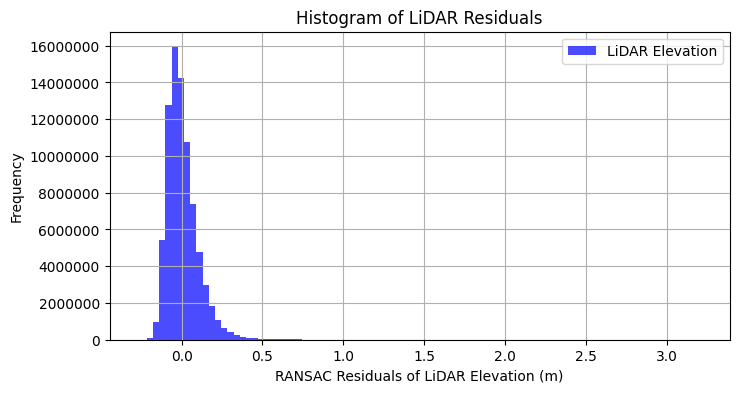

In [ ]:
# Plot the distribution of the LiDAR values

# Config 
lidar_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/data/pondinlet_lidar"
patch_size = 256 

def merge_lidar_files(lidar_files):
    src_files_to_mosaic = [rasterio.open(fp) for fp in lidar_files]
    mosaic, mosaic_transform = merge(src_files_to_mosaic)
    lidar_meta = src_files_to_mosaic[0].meta.copy()
    lidar_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": mosaic_transform
    })
    for src in src_files_to_mosaic:
        src.close()
    return mosaic[0], mosaic_transform, lidar_meta

# Mosaic LIDAR files
lidar_files = glob(os.path.join(lidar_dir, "*1m.tif"))
lidar_array, lidar_transform, lidar_meta = merge_lidar_files(lidar_files)

# Replace -9999 with NaN
lidar_array = np.where(lidar_array == -9999, np.nan, lidar_array)

# Get min and max LiDAR values
lidar_min = np.nanmin(lidar_array)
lidar_max = np.nanmax(lidar_array)
lidar_mean = np.nanmean(lidar_array)
print(f"Mean LiDAR value: {lidar_mean}")
print(f"Min LiDAR value: {lidar_min}")
print(f"Max LiDAR value: {lidar_max}")

# Get histogram of Lidar values
plt.figure(figsize=(8, 4))
plt.hist(lidar_array[~np.isnan(lidar_array)].flatten(), bins=100,
            color='blue', alpha=0.7, label='LiDAR Elevation')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Histogram of LiDAR Residuals")
plt.xlabel("RANSAC Residuals of LiDAR Elevation (m)")
plt.ylabel("Frequency")
plt.xlim(lidar_min, lidar_max)
plt.legend()
plt.grid()
plt.show()

Processing LiDAR directory: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/pondinlet_lidar


Mean LiDAR value: 0.006983673200011253
Min LiDAR value: -0.44536957144737244
Max LiDAR value: 3.3873047828674316
Processing LiDAR directory: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/tuq_lidar
Mean LiDAR value: 0.09737030682902002
Min LiDAR value: -0.47000000000000003
Max LiDAR value: 4.0200000000000005
Processing LiDAR directory: /cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_lidar
Mean LiDAR value: 0.03192677825333896
Min LiDAR value: -0.26
Max LiDAR value: 3.12


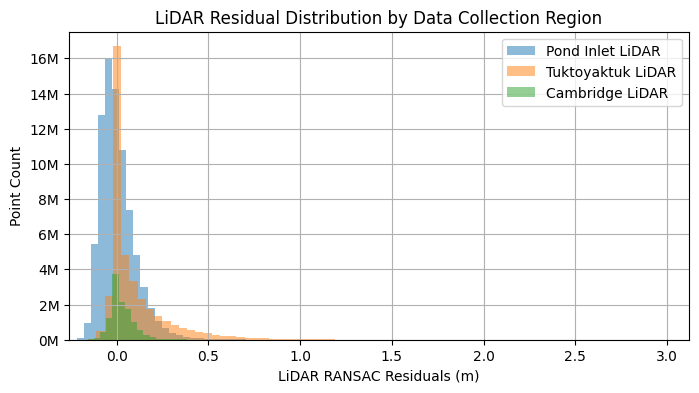

In [ ]:
# Plot the overlayed distribution of the LiDAR values

# Config 
pondinlet_lidar = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/pondinlet_lidar"
tuq_lidar = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/tuq_lidar"
cambridge_lidar = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/cambridge_lidar"

# Plot title dict
plot_titles = {
    pondinlet_lidar: "Pond Inlet LiDAR",
    tuq_lidar: "Tuktoyaktuk LiDAR",
    cambridge_lidar: "Cambridge LiDAR"
}

# Patch size 
patch_size = 256 

def merge_lidar_files(lidar_files):
    src_files_to_mosaic = [rasterio.open(fp) for fp in lidar_files]
    mosaic, mosaic_transform = merge(src_files_to_mosaic)
    lidar_meta = src_files_to_mosaic[0].meta.copy()
    lidar_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": mosaic_transform
    })
    for src in src_files_to_mosaic:
        src.close()
    return mosaic[0], mosaic_transform, lidar_meta

lidar_arrays = {}
# Mosaic LIDAR files
for lidar_dir in [pondinlet_lidar, tuq_lidar, cambridge_lidar]:
    print(f"Processing LiDAR directory: {lidar_dir}")
    lidar_files = glob(os.path.join(lidar_dir, "*.tif"))
    lidar_array, lidar_transform, lidar_meta = merge_lidar_files(lidar_files)

    # Replace -9999 with NaN
    lidar_array = np.where(lidar_array == -9999, np.nan, lidar_array)

    # Store the array for later use
    lidar_arrays[lidar_dir] = lidar_array

    # Get min and max LiDAR values
    lidar_min = np.nanmin(lidar_array)
    lidar_max = np.nanmax(lidar_array)
    lidar_mean = np.nanmean(lidar_array)
    print(f"Mean LiDAR value: {lidar_mean}")
    print(f"Min LiDAR value: {lidar_min}")
    print(f"Max LiDAR value: {lidar_max}")

    
# Get overlayed histogram of Lidar values
plt.figure(figsize=(8, 4))
for lidar_dir, lidar_array in lidar_arrays.items():
    plt.hist(lidar_array[~np.isnan(lidar_array)].flatten(), bins=100,
             alpha=0.5, label=f'{plot_titles[lidar_dir]}')
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f"{x * 1e-6:,.0f}M" if np.isfinite(x) else "")
)
plt.title("LiDAR Residual Distribution by Data Collection Region")
plt.xlabel("LiDAR RANSAC Residuals (m)")
plt.ylabel("Point Count")
plt.xlim(lidar_min, lidar_max)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Get a symmetric range which covers 99.5% of the data

lower_bound = np.nanpercentile(lidar_array, 0.25)
upper_bound = np.nanpercentile(lidar_array, 99.75)
print(f"Lower bound (0.25%): {lower_bound}")
print(f"Upper bound (99.75%): {upper_bound}")

# Print min, max, and mean
print(f"Min LiDAR value: {lidar_min}")
print(f"Max LiDAR value: {lidar_max}")
print(f"Mean LiDAR value: {lidar_mean}")

Lower bound (0.25%): -0.16531983017921448
Upper bound (99.75%): 0.5227751731872559
Min LiDAR value: -0.44536957144737244
Max LiDAR value: 3.3873047828674316
Mean LiDAR value: 0.006983673200011253


Downsampled shape: (317, 620)


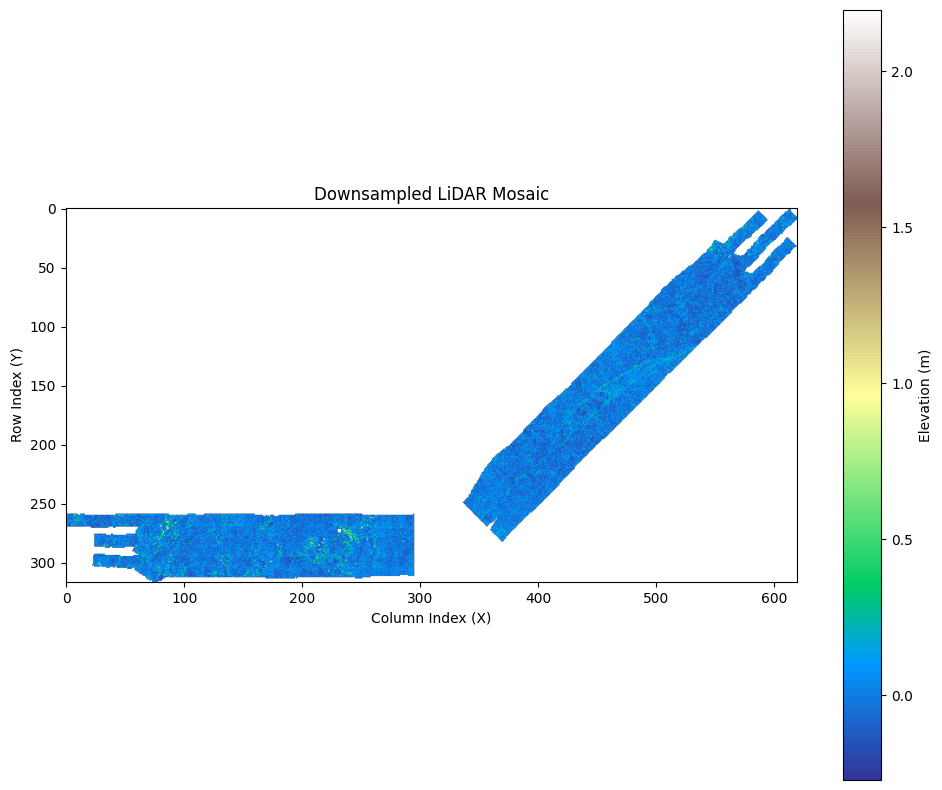

In [ ]:
# Split LiDAR regions

def plot_lidar_mosaic(lidar_array, title="LiDAR Mosaic", vmin=None, vmax=None):
    """
    Plot the LiDAR mean elevation mosaic with axis labels and a colorbar.

    Parameters:
    - lidar_array: np.ndarray of shape (H, W) 
    - title: plot title
    - vmin, vmax: value range for color normalization (optional)
    """

    lidar_array = np.where(np.isnan(lidar_array), np.nan, lidar_array)

    plt.figure(figsize=(10, 8))
    im = plt.imshow(lidar_array, cmap="terrain", vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Elevation (m)")
    plt.title(title)
    plt.xlabel("Column Index (X)")
    plt.ylabel("Row Index (Y)")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Plot the LiDAR mosaic
# Downsample for visualization (every 50th pixel)
downsample_factor = 50
lidar_small = lidar_array[::downsample_factor, ::downsample_factor]

print("Downsampled shape:", lidar_small.shape)
plot_lidar_mosaic(lidar_small, title="Downsampled LiDAR Mosaic")

/tmp/ipykernel_2395804/1470837196.py:25: RuntimeWarning: Mean of empty slice
  downsampled = np.nanmean(padded_arr.reshape(new_h, factor, new_w, factor), axis=(1, 3))


Original shape: (15822, 30977)
Downsampled shape: (317, 620)


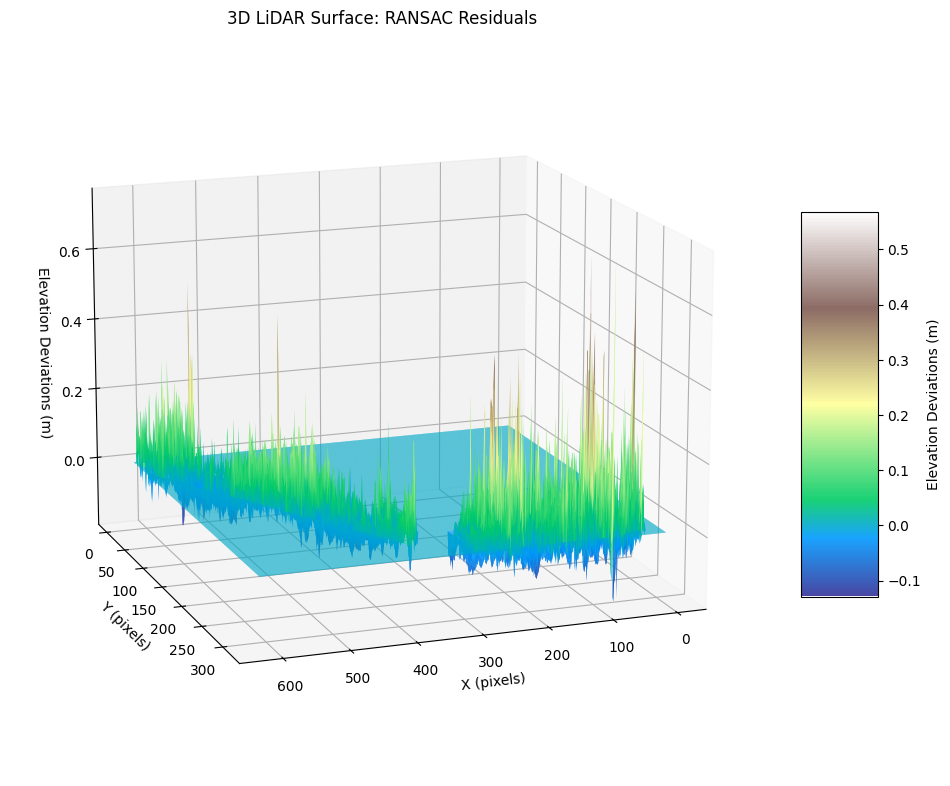

In [ ]:
# 3D Surface Plot of LiDAR Data

def downsample_array(arr, factor=10):
    """
    Downsamples a 2D NumPy array by a given factor, using mean aggregation.

    Parameters:
    - arr: The original 2D NumPy array.
    - factor: The downsampling factor (e.g., a factor of 10 reduces the
              resolution by 10x in both height and width).

    Returns:
    - The downsampled 2D NumPy array.
    """
    # Get dimensions
    h, w = arr.shape
    
    # Pad the array with NaNs to make it divisible by the factor
    pad_h = factor - (h % factor) if h % factor != 0 else 0
    pad_w = factor - (w % factor) if w % factor != 0 else 0
    padded_arr = np.pad(arr, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=np.nan)
    
    # Reshape the array into blocks and calculate the mean of each block
    # reshapes to (new_h, factor, new_w, factor)
    new_h, new_w = padded_arr.shape[0] // factor, padded_arr.shape[1] // factor
    downsampled = np.nanmean(padded_arr.reshape(new_h, factor, new_w, factor), axis=(1, 3))
    
    return downsampled

def plot_lidar_3d_surface(lidar_array, title="3D LiDAR Surface: RANSAC Residuals"):
    """
    Creates a 3D surface plot of the LiDAR elevation data.
    
    Parameters:
    - lidar_array: np.ndarray (2D) containing elevation values.
    - title: The title for the plot.
    """
    # Replace NaNs with zero
    lidar_array = np.where(np.isnan(lidar_array), 0, lidar_array)
    
    # Get the dimensions of the lidar array
    height, width = lidar_array.shape

    # Create a meshgrid for the X and Y coordinates
    x_coords = np.arange(0, width)
    y_coords = np.arange(0, height)
    X, Y = np.meshgrid(x_coords, y_coords)

    # Create the figure and a 3D axis object
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create the surface plot
    surface = ax.plot_surface(
        X, Y, lidar_array, 
        cmap='terrain', 
        alpha=0.9,
        edgecolor='none', 
        rstride=1, cstride=1
    )
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Elevation Deviations (m)')
    ax.set_title(title)

    # Add a color bar for reference
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5, label='Elevation Deviations (m)')

    # Set the viewing angle
    ax.view_init(elev=15, azim=70) # Controls perspective

    plt.show()

# Downsample the array for plotting
downsampled_lidar_array = downsample_array(lidar_array, factor=50)

print(f"Original shape: {lidar_array.shape}")
print(f"Downsampled shape: {downsampled_lidar_array.shape}")

# Plot the 3D surface of the LiDAR data
plot_lidar_3d_surface(downsampled_lidar_array)

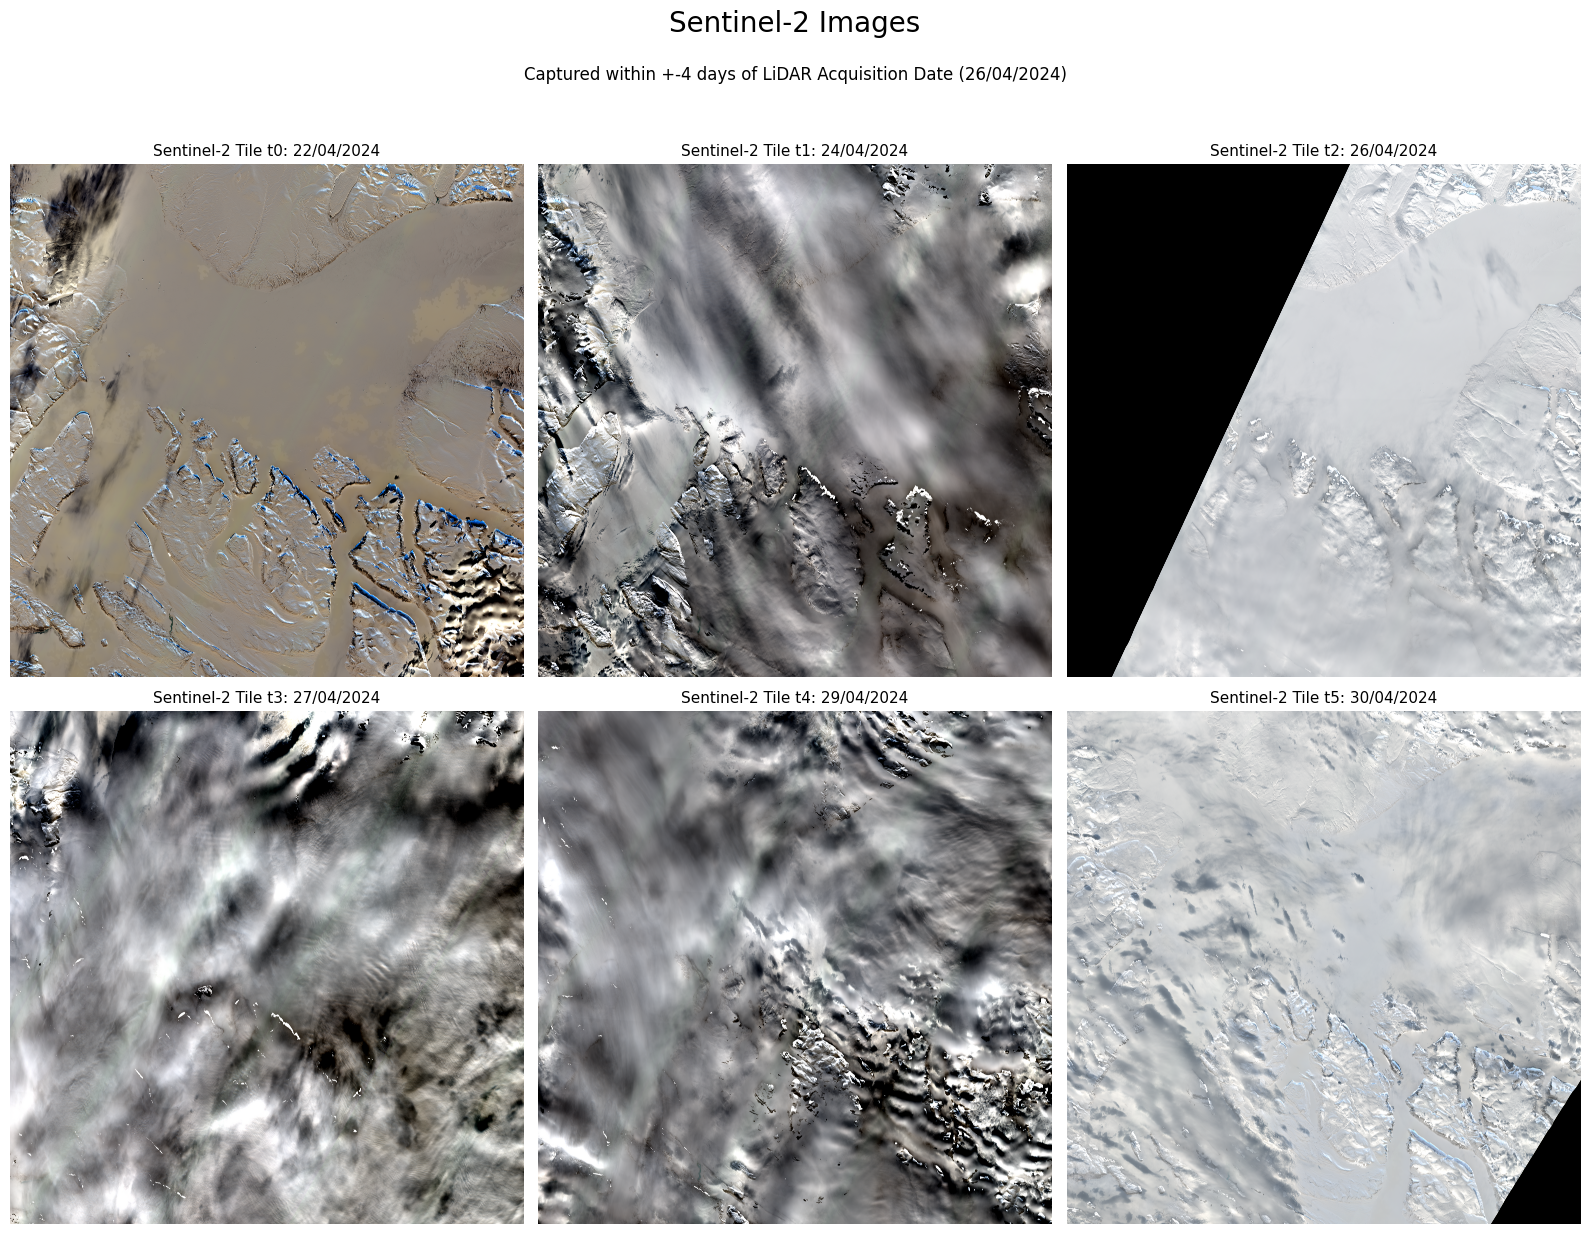

In [ ]:
# Visualize the six images of interest

sentinel_granule_dirs = [
    "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/pondinlet_sentinel_downloads/S2A_MSIL2A_20240422T173911_N0510_R098_T17XNA_20240423T004122.SAFE/GRANULE",
    "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/pondinlet_sentinel_downloads/S2B_MSIL2A_20240424T172859_N0510_R055_T17XNA_20240424T195611.SAFE/GRANULE",
    "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/pondinlet_sentinel_downloads/S2A_MSIL2A_20240426T171901_N0510_R012_T17XNA_20240426T223050.SAFE/GRANULE",
    "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/pondinlet_sentinel_downloads/S2B_MSIL2A_20240427T173859_N0510_R098_T17XNA_20240427T200733.SAFE/GRANULE",
    "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/pondinlet_sentinel_downloads/S2A_MSIL2A_20240429T172901_N0510_R055_T17XNA_20240429T222851.SAFE/GRANULE",
    "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/raw_data/pondinlet_sentinel_downloads/S2B_MSIL2A_20240430T174909_N0510_R141_T17XNA_20240430T201515.SAFE/GRANULE",
]

main_title = "Sentinel-2 Images"
sub_title  = "Captured within +-4 days of LiDAR Acquisition Date (26/04/2024)"
subplot_titles = [
    "Sentinel-2 Tile t0: 22/04/2024",
    "Sentinel-2 Tile t1: 24/04/2024",
    "Sentinel-2 Tile t2: 26/04/2024",
    "Sentinel-2 Tile t3: 27/04/2024",
    "Sentinel-2 Tile t4: 29/04/2024",
    "Sentinel-2 Tile t5: 30/04/2024",
]

def find_img_data_r10m(granule_root):
    """
    Given a path ending in .../SAFE/GRANULE, find the IMG_DATA/R10m directory
    inside the single granule subfolder. Returns the path.

    """
    granule_subdirs = [
        os.path.join(granule_root, d)
        for d in os.listdir(granule_root)
        if os.path.isdir(os.path.join(granule_root, d))
    ]
    for g in granule_subdirs:
        candidate = os.path.join(g, "IMG_DATA", "R10m")
        if os.path.isdir(candidate):
            return candidate


def load_rgb_r10m(img_data_r10m_dir):
    """
    Load B04 (red), B03 (green), B02 (blue) as float32 arrays and stack into RGB.
    """
    def find_band(filename_part):
        matches = [os.path.join(img_data_r10m_dir, f)
                   for f in os.listdir(img_data_r10m_dir)
                   if filename_part in f]
        return matches[0]

    b04_path = find_band("B04_10m.jp2")
    b03_path = find_band("B03_10m.jp2")
    b02_path = find_band("B02_10m.jp2")

    with rasterio.open(b04_path) as r:
        b04 = r.read(1).astype(np.float32)
    with rasterio.open(b03_path) as g:
        b03 = g.read(1).astype(np.float32)
    with rasterio.open(b02_path) as b:
        b02 = b.read(1).astype(np.float32)

    rgb = np.stack([b04, b03, b02], axis=-1)
    return rgb


def percentile_normalize(img, lower=2, upper=98):
    """
    Robust percentile-based normalization to [0,1] per channel.
    Handles edge cases where p_high == p_low.
    """
    img = img.copy()
    out = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[-1]):
        p_low, p_high = np.percentile(img[..., i], (lower, upper))
        if p_high <= p_low:
            # fallback to simple min/max
            vmin, vmax = img[..., i].min(), img[..., i].max()
        else:
            vmin, vmax = p_low, p_high
        denom = (vmax - vmin) if (vmax - vmin) != 0 else 1.0
        out[..., i] = np.clip((img[..., i] - vmin) / denom, 0, 1)
    return out


# Load all six RGB composites
rgb_images = []
for granule_dir in sentinel_granule_dirs:
    img_data_r10m = find_img_data_r10m(granule_dir)
    rgb = load_rgb_r10m(img_data_r10m)
    rgb_norm = percentile_normalize(rgb, lower=2, upper=98)
    rgb_images.append(rgb_norm)

# Plot 2×3 tiled figure
fig, axes = plt.subplots(2, 3, figsize=(16, 13))
fig.suptitle(main_title, fontsize=20, y=0.98)
fig.text(0.5, 0.93, sub_title, ha="center", va="center", fontsize=12)

for idx, ax in enumerate(axes.ravel()):
    ax.imshow(rgb_images[idx])
    ax.set_title(subplot_titles[idx], fontsize=11)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()